# k-means

In this notebook, I will explore k-means clustering as a way to determine how many clusters there are. I will be using TF-IDF feature representation and make use of some dimentionality reduction techniques such as PCA to reduce the number of features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# import data
cleaned = pd.read_pickle('data/features.pkl')

In [3]:
cleaned.head()

,original_text,label,preprocessed,word_count,avg_word_count,syllable_count,uncommon,difficult_words,stem,discourse,cohesive_features,flesch,dale,mcalpine,nouns_adjs,normalized
0,There is manuscript evidence that Austen conti...,1,"[there, is, manuscript, evidence, that, austen...",35,4.485714,1.371429,14,7,there is manuscript evid that austen continu t...,4,2,52.87,11.24,48.0,0.228571,there is manuscript evidence that austen conti...
1,"In a remarkable comparative analysis , Mandaea...",1,"[in, a, remarkable, comparative, analysis, man...",19,6.000000,1.789474,14,8,there is manuscript evid that austen continu t...,2,1,35.27,14.55,23.0,0.315789,in a remarkable comparative analysis mandaean ...
2,"Before Persephone was released to Hermes , who...",1,"[before, persephone, was, released, to, hermes...",40,4.725000,1.400000,15,9,there is manuscript evid that austen continu t...,7,3,47.80,11.15,57.0,0.175000,before persephone was released to hermes who h...
3,Cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",32,6.281250,1.781250,22,14,there is manuscript evid that austen continu t...,0,1,22.08,14.60,38.0,0.593750,cogeneration plants are commonly found in dist...
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[geneva, is, the, city, in, switzerland, after...",20,4.650000,1.350000,7,4,there is manuscript evid that austen continu t...,0,2,68.10,8.58,29.0,0.400000,geneva is the city in switzerland after zürich...


### Step 1:

Here, we will apply k-means clustering to a set of text documents to gain some insight into the nature of the content. 

This scenario uses the TfidfVectorizer class to convert each text to a numeric vector. 

In [4]:
def vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000):
    """
    This function returns:
    - a matrix X with one row per document (review). Each row is a sparse
    vector containing tf.idf term weights for the words in the document.
    """
    df = pd.read_pickle('data/features.pkl')['normalized']
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 min_df=2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        instances = df.values[0:top_n]
    else:
        instances = df.values
    
    X = vectorizer.fit_transform(instances) 
    
    return (X, vectorizer, instances)

In [5]:
vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000)[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's build a function that takes the various numerical vectors and reduces them into two principle componments

In [6]:
def pca(npca_components):
    """
    Reduces dimensions of text into PCA space
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    X, vectorizer, review_instances = vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000)
    
    # convert vectorized text into dataframe 
    df_x_tdidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    
    #Reduce TFIDF features X, to 4 Principle components (Assessing impact)
    X_pca = PCA(n_components=npca_components).fit_transform(StandardScaler().fit_transform(df_x_tdidf))
    
    # convert pca features to dataframe:
    df_xpca = pd.DataFrame(X_pca, columns = ["pca"+str(i) for i in range(1, npca_components+1)])
    
    return df_xpca


In [ ]:
#df_pca = pca(2)

In [8]:
df_pca.to_pickle("data/pca2.pkl")

## Next, let's find the optimal number of clusters

#### K-Means: Inertia

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.

To find the optimal K for a dataset we use the Elbow method. The optimal K is the point where the decrease in inertia begins to slow (looks like an elbow)

In [7]:
# first let's try with a sample
df = pd.read_pickle('data/features.pkl')
sample= df['normalized'].sample(n=100000, random_state=42)

sample

66852     damn was given poor reviews by the daily star ...
242486    this danger made the asteroid level on the tor...
67594     hattusili and the egyptian pharaoh ramesses ii...
340029    it is found in the region pays de la loire in ...
342307        shawnee park is a park in louisville kentucky
                                ...                        
281685    an atlas is a collection of maps or manifolds ...
271673                  most people in the uk speak english
301321              the fairly oddparents and danny phantom
256255    its first section opened in which makes it old...
211427    villigen is a municipality of the district of ...
Name: normalized, Length: 100000, dtype: object

In [8]:
def vectorized_sample(top_n = -1, ngram_range = (1,2), max_features = 200):
    """
    This function returns:
    - a matrix X with one row per document (review). Each row is a sparse
    vector containing tf.idf term weights for the words in the document.
    """
    df = sample
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 min_df=2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        instances = df.values[0:top_n]
    else:
        instances = df.values
    
    X = vectorizer.fit_transform(instances) 
    
    return (X, vectorizer, instances)

In [9]:
inertia = []
labels = []

def elbow_method():
    """Returns optimal k_clusters in the range of 2 to 10"""
    X, vectorizer, review_instances = vectorized_sample(top_n = -1, ngram_range = (1,2), max_features = 200)

    for k in tqdm(range(2, 15)): 
        km = KMeans(n_clusters=k, max_iter=50,random_state=42).fit(X.toarray())
        labels.append(km.labels_)
        inertia.append(km.inertia_)
    return labels, inertia

In [10]:
elbow_method()

100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


([array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([2, 2, 2, ..., 2, 2, 2], dtype=int32),
  array([2, 2, 2, ..., 2, 2, 2], dtype=int32),
  array([3, 3, 3, ..., 3, 3, 3], dtype=int32),
  array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([6, 6, 6, ..., 6, 6, 6], dtype=int32),
  array([0, 1, 1, ..., 1, 1, 1], dtype=int32),
  array([6, 6, 6, ..., 6, 6, 6], dtype=int32),
  array([2, 2, 1, ..., 2, 3, 2], dtype=int32),
  array([5, 2, 9, ..., 2, 2, 2], dtype=int32),
  array([4, 5, 5, ..., 5, 5, 5], dtype=int32),
  array([ 3,  3,  3, ...,  3,  3, 12], dtype=int32),
  array([1, 1, 4, ..., 1, 1, 1], dtype=int32)],
 [77115.49338430513,
  75332.82902175152,
  74177.98666744711,
  73814.89877845588,
  72864.50516855363,
  71698.85559375983,
  71435.73474751961,
  70768.4239738978,
  71103.18406220648,
  70488.58212989259,
  69451.51611731714,
  69609.191524503,
  68959.8767501848])

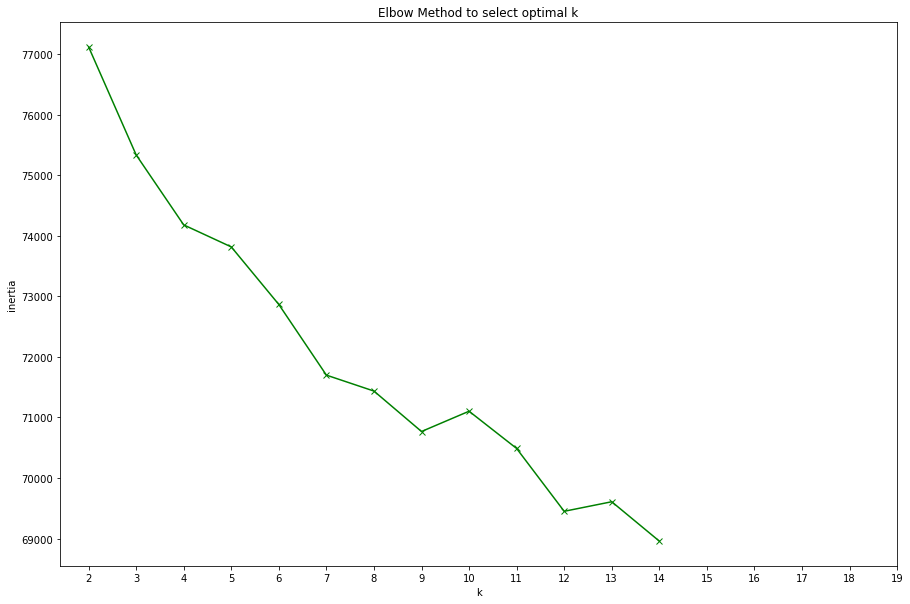

In [11]:
# Elbow Plot: 
plot = plt.figure(figsize= (15,10))
plot = plt.plot(range(2,15), inertia, 'bx-', color = 'green')
plot= plt.xticks(list(range(2,20)))
plot= plt.xlabel('k')
plot= plt.ylabel('inertia')
plot= plt.title('Elbow Method to select optimal k')

In [12]:
def clusters():
    """
    We're looking for clusterings that have a high Calinski-Harabasz index
    but a low Davies-Bouldin score.
    """
    from sklearn.cluster import KMeans
    from sklearn import metrics
    from sklearn.metrics import pairwise_distances
    
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)

    metric_values = []
    for i in tqdm(range(2,10)):
        kmeans_model = KMeans(n_clusters = i, init='k-means++', max_iter=50,n_init=1, random_state=42)
        kmeans_model.fit(X.toarray()) 
        labels = kmeans_model.labels_
        calinkski = metrics.calinski_harabasz_score(X.toarray(), labels) #The score is higher when clusters are dense 
       # and well separated, which relates to a standard concept of a cluster.

        davies = metrics.davies_bouldin_score(X.toarray(), labels) #lower values indicating better clustering.
        metric_values.append((i,calinkski,davies))
    return metric_values

In [13]:
clusters()

100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


[(2, 1157.135453677715, 2.8991590290682496),
 (3, 1028.816353424557, 3.657149486854968),
 (4, 920.1487515914265, 3.2364390359230204),
 (5, 1090.8387471088038, 3.162357886674922),
 (6, 1212.1009988308258, 2.8205709316927567),
 (7, 1059.5257728769925, 2.7423221334453407),
 (8, 1059.0765942861842, 2.4337792491999153),
 (9, 1092.04091056578, 2.3886786371735282)]

In [22]:
# Calculate silhouette_score 
def silhouette():
    sil_score={}
    # Calculate silhouette_score: (Optional- On a smaller sample size. This should be highest)
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)
    for k in tqdm(range(2,15)): 
        km_optimal = KMeans(n_clusters=k, max_iter=100, n_init=1, init='k-means++', random_state=0).fit(X)
        sil_score[k] = silhouette_score(X, km_optimal.labels_, sample_size= 100000, random_state = 0)
    return sil_score

In [23]:
silhouette()

100%|██████████| 13/13 [40:46<00:00, 188.19s/it]


{2: 0.10742470952460115,
 3: 0.09824967488816645,
 4: 0.09997087851355904,
 5: 0.09892332139556446,
 6: 0.10123002012848527,
 7: 0.10153833205601459,
 8: 0.10959727921662982,
 9: 0.1111285570611287,
 10: 0.11765289480040872,
 11: 0.12963264469664867,
 12: 0.13435074331746968,
 13: 0.14073025445036252,
 14: 0.14279797297376054}

### Observations and conclusions

It seems that the ideal number of clusters according the the elbow method is 9. However, the lowest Silhouette score is for k = 5. One way to mitigate this challenge is to pick a number between 5 and 9. 7 might seem like a good choice given our results

In [16]:
def kmeans_clusters():
    """
    Returns a list that has k elements, where k is the optimal number of clusters
    Each of these k elements contains a list of the top 10 terms (strings) for that cluster. 
    These terms are sorted by highest to lowest term weight value as stored in the cluster centroid.
    """
    kmeans=KMeans(n_clusters=6,init='k-means++',max_iter=100,n_init=1,random_state=42)
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)
    
    kmeans.fit(X)
    
    centroids=kmeans.cluster_centers_
    columns=vectorizer.get_feature_names()
    centers = [list(zip(columns,center)) for center in centroids]
    sorted_words = [sorted(each,key=lambda x:x[1],reverse=True)[:10]for each in centers]
    result=[[tup[0] for tup in each] for each in sorted_words]
  
    return result

In [17]:
kmeans_clusters()

[['france',
  'commune',
  'department',
  'region',
  'department region',
  'aisne',
  'north',
  'northern',
  'la',
  'southern'],
 ['known',
  'best',
  'born',
  'american',
  'world',
  'television',
  'english',
  'february',
  'species',
  'used'],
 ['new',
  'time',
  'new york',
  'york',
  'city',
  'south',
  'world',
  'american',
  'year',
  'born'],
 ['use',
  'used',
  'people',
  'term',
  'usually',
  'english',
  'common',
  'time',
  'different',
  'make'],
 ['high',
  'school',
  'university',
  'including',
  'began',
  'city',
  'used',
  'park',
  'north',
  'united'],
 ['born',
  'city',
  'used',
  'called',
  'united',
  'world',
  'states',
  'people',
  'american',
  'football']]

Let's play around with values for the parameters of TfidfVectorizer, to see how the results change, because the results of this kind of clustering can be very sensitive to those parameters, which control how the text is processed, what defines what a "term" is, and which words are kept as features in the clustering.

In [18]:
def vectorized_diffvalues(top_n = -1, ngram_range = (2,3), max_features = 1000):
    """
    This function returns:
    - a matrix X with one row per document (review). Each row is a sparse
    vector containing tf.idf term weights for the words in the document.
    """
    df = sample
    vectorizer = TfidfVectorizer(max_features=max_features, max_df= 0.5,
                                 min_df= 2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        instances = df.values[0:top_n]
    else:
        instances = df.values
    
    X = vectorizer.fit_transform(instances) 
    
    return (X, vectorizer, instances)

In [19]:
def kmeans_clusters_experiment():
    """
    Returns a list that has k elements, where k is the optimal number of clusters
    Each of these k elements contains a list of the top 10 terms (strings) for that cluster. 
    These terms are sorted by highest to lowest term weight value as stored in the cluster centroid.
    """
    X, vectorizer, instances = vectorized_diffvalues(top_n = -1, ngram_range = (2,3), max_features = 1000)
    kmeans=KMeans(n_clusters=6,init='k-means++',max_iter=100,n_init=1,random_state=42)

    
    kmeans.fit(X)
    
    centroids=kmeans.cluster_centers_
    columns=vectorizer.get_feature_names()
    centers = [list(zip(columns,center)) for center in centroids]
    sorted_words = [sorted(each,key=lambda x:x[1],reverse=True)[:10]for each in centers]
    result=[[tup[0] for tup in each] for each in sorted_words]
  
    return result

In [20]:
kmeans_clusters_experiment()

[['commune department region',
  'department region france',
  'region france',
  'commune department',
  'department region',
  'southern france',
  'aargau switzerland',
  'abbottabad district',
  'academy award',
  'according census'],
 ['united states',
  'new york',
  'united kingdom',
  'best known',
  'prime minister',
  'north america',
  'department north',
  'department north france',
  'north france',
  'high school'],
 ['football player',
  'japanese football',
  'japanese football player',
  'brazilian football player',
  'brazilian football',
  'football player plays',
  'player plays',
  'born july',
  'born february',
  'born january'],
 ['middle ages',
  'roman empire',
  'western europe',
  'catholic church',
  'eastern europe',
  'england scotland',
  'commonly used',
  'latin word',
  'middle east',
  'byzantine empire'],
 ['football club',
  'club plays',
  'football club plays',
  'club based',
  'football club based',
  'english football',
  'association football

### Information Gain for discriminative clusters

Ideally, we'd like to find slighly better representative words for each cluster that are somewhat *specific* to that cluster and not others, i.e. words that distinguish reviews in that cluster from reviews in other clusters. To use the technical term, we want terms that are *discriminative* with respect to the clusters, not just descriptive. We will make use of Infomration gain to help us come up with such clusters

In [27]:
from scipy.stats import entropy

def compute_distinctive_term_score(T, T_a):   
    # First compute information gain.
    IG = entropy(T) - entropy(T_a) 
    #if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms whose *absence* is notable, 
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    
    if (T_a[0] < T_a[1]):
        score = -IG  
    else:
        score = IG
    return score

# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index+1:, :])).sum(axis=0)
    result = np.vstack((row0, row1))
    return result

def cluster_labeling():
    kmeans=KMeans(n_clusters=7,init='k-means++',max_iter=100,n_init=1,random_state=42)
    X, vectorizer, instances = vectorized_diffvalues(top_n = -1, ngram_range = (1,2), max_features = 1000)
    kmeans.fit(X)
    centroids=kmeans.cluster_centers_
    centroids=np.array(centroids) #This should be an array with seven (7) rows, one row per cluster, 
    #and 1000 columns (one column per word/term in the vocabulary produced by the vectorizer).
    final = []
    
    for i in range(centroids.shape[0]):
        
        ctm = one_vs_all_count_matrix(centroids,i)#the first row has the weights of words in this cluster 𝑐  
        #(which is the same as L[c, :]), and the second row has the aggregate summed weights of the words 
        #across all other clusters. The columns are the same as  𝐿 : one column per term in the vocabulary.
        T_c = ctm.sum(axis=1)
        T_c = T_c/sum(T_c)
        result = []
        for i in range(centroids.shape[1]):
            T_w=ctm[:,i]
            T_w=T_w/sum(T_w)
            info_gain = compute_distinctive_term_score(T_c, T_w)
            result.append(info_gain)
            
        terms_score=list(zip(vectorizer.get_feature_names(),result))
        terms_score=sorted(terms_score,key=lambda x:x[1],reverse=True)[:5]
        terms_score=[each[0] for each in terms_score]
        final.append(terms_score)
    return final

cluster_labeling()

[['aisne department',
  'aquitaine gironde',
  'calvados department',
  'commune aisne',
  'commune calvados'],
 ['million', 'bbc', 'low', 'china', 'africa'],
 ['york city', 'new york', 'new zealand', 'york', 'zealand'],
 ['points', 'flag', 'tropical', 'race', 'ice'],
 ['football player',
  'japanese football',
  'brazilian football',
  'born september',
  'born march'],
 ['family', 'wife', 'married', 'branch', 'tree'],
 ['cells', 'municipality district', 'district', 'study', 'refer']]

### Visualization

In [39]:
# scatter plot using optimal clusters
tokens = {}
def optimal_k(num = 200, k = 7):
    X, vectorizer, instances = vectorized_diffvalues(top_n = -1, ngram_range = (1,2), max_features = 1000)
    km_best = KMeans(n_clusters=k, max_iter=100, n_init=1, init='k-means++', random_state=42).fit(X)
    
    # Get cluster centers: 
    cluster_center = pd.DataFrame(km_best.cluster_centers_, columns = vectorizer.get_feature_names()).T
    
    for i in cluster_center.columns: 
    
        tokens[i] = cluster_center[i].sort_values(ascending = False)[:num].index
        
    central_words = pd.DataFrame(tokens)
    central_words.columns = ["cluster_"+str(i) for i in range(1, k+1)]
    return km_best, central_words

In [40]:
optimal_k(num = 200, k = 7)

(KMeans(max_iter=100, n_clusters=7, n_init=1, random_state=42),
              cluster_1  cluster_2      cluster_3 cluster_4        cluster_5  \
 0              commune    million            new      time             born   
 1               france       live           york      team           player   
 2           department  countries       new york  national         football   
 3               region   northern    new zealand     named  football player   
 4    department region    romania        zealand    season         american   
 ..                 ...        ...            ...       ...              ...   
 195          performed    systems           head      hall        rock band   
 196             period       film         police   spanish           worked   
 197             person     square  hockey league  original             poet   
 198              peter      music            led     dutch           leader   
 199           physical      named          parts   curr

In [ ]:
# Prepare to plot clusters and its centroids: 

# Get unique labels: 
label = km_best.fit_predict(X_pca)
u_labels = np.unique(label)

_ = plt.figure(figsize= (15,10))
for i in u_labels: 
    _ = plt.scatter(x = X_pca[label == i , 0] , y = X_pca[label == i , 1] , label = "cluster_"+str(i+1), \
                    cmap=plt.get_cmap('viridis'), alpha = 0.5)
    _ = plt.xlabel('PCA1')
    _ = plt.ylabel('PCA2')
    _ = plt.title('K-Means Clusters with centroids on reduced Principle Components')
    _ = plt.legend()

for i in km_best.cluster_centers_:  
    _ = plt.scatter(x = i[0],y = i[1],  s = 80, marker='o', label = "cluster_"+str(i+1),\
                    c= 'black', edgecolors='white', alpha = 0.8)